<a href="https://colab.research.google.com/github/meituan/YOLOv6/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone and install MT-YOLOv6
# !git clone https://github.com/meituan/YOLOv6.git
# !cd YOLOv6
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [14]:
#@title Set-up model. { run: "auto" }
checkpoint:str ="yolov6n" #@param ["yolov6s", "yolov6n", "yolov6t"]
device:str = "cpu"#@param ["gpu", "cpu"]
half:bool = False #@param {type:"boolean"}


import os, requests, torch, math, cv2
import numpy as np
import PIL
#Change directory so that imports wortk correctly
if os.getcwd()=="/content":
  os.chdir("YOLOv6")
from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer

from typing import List, Optional
#Download weights
if not os.path.exists(f"{checkpoint}.pt"):
  print("Downloading checkpoint...")
  os.system(f"""wget -c https://github.com/meituan/YOLOv6/releases/download/0.3.0/{checkpoint}.pt""")

#Set-up hardware options
cuda = device != 'cpu' and torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
  
def check_img_size(img_size, s=32, floor=0):
  def make_divisible( x, divisor):
    # Upward revision the value x to make it evenly divisible by the divisor.
    return math.ceil(x / divisor) * divisor
  """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
  if isinstance(img_size, int):  # integer i.e. img_size=640
      new_size = max(make_divisible(img_size, int(s)), floor)
  elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
      new_size = [max(make_divisible(x, int(s)), floor) for x in img_size]
  else:
      raise Exception(f"Unsupported type of img_size: {type(img_size)}")

  if new_size != img_size:
      print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
  return new_size if isinstance(img_size,list) else [new_size]*2

def process_image(path, img_size, stride, half):
  '''Process image before image inference.'''
  try:
    from PIL import Image
    img_src = np.asarray(Image.open(url))
    assert img_src is not None, f'Invalid image: {path}'
  except Exception as e:
    LOGGER.warning(e)
  image = letterbox(img_src, img_size, stride=stride)[0]

  # Convert
  image = image.transpose((2, 0, 1))  # HWC to CHW
  image = torch.from_numpy(np.ascontiguousarray(image))
  image = image.half() if half else image.float()  # uint8 to fp16/32
  image /= 255  # 0 - 255 to 0.0 - 1.0

  return image, img_src


model = DetectBackend(f"./{checkpoint}.pt", device=device)
stride = model.stride
class_names = load_yaml("./data/coco.yaml")['names']

if half & (device.type != 'cpu'):
  model.model.half()
else:
  model.model.float()
  half = False

if device.type != 'cpu':
  model(torch.zeros(1, 3, *img_size).to(device).type_as(next(model.model.parameters())))  # warmup


Loading checkpoint from ./yolov6n.pt



Fusing model...
C:\Users\Maryk\AppData\Roaming\Python\Python310\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


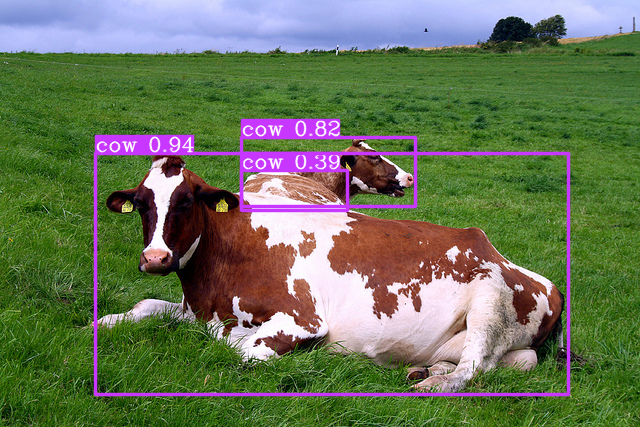

In [15]:
#@title Run YOLOv6 on an image from a URL. { run: "auto" }
url:str = "./test_coco.jpg" #@param {type:"string"}
hide_labels: bool = False #@param {type:"boolean"}
hide_conf: bool = False #@param {type:"boolean"}



img_size:int = 640#@param {type:"integer"}

conf_thres: float =.25 #@param {type:"number"}
iou_thres: float =.45 #@param {type:"number"}
max_det:int =  1000#@param {type:"integer"}
agnostic_nms: bool = False #@param {type:"boolean"}


img_size = check_img_size(img_size, s=stride)

img, img_src = process_image(url, img_size, stride, half)
img = img.to(device)
if len(img.shape) == 3:
    img = img[None]
    # expand for batch dim
pred_results = model(img)
classes:Optional[List[int]] = None # the classes to keep
det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]

gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
img_ori = img_src.copy()
if len(det):
  det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4], img_src.shape).round()
  for *xyxy, conf, cls in reversed(det):
      class_num = int(cls)
      label = None if hide_labels else (class_names[class_num] if hide_conf else f'{class_names[class_num]} {conf:.2f}')
      Inferer.plot_box_and_label(img_ori, max(round(sum(img_ori.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True))
PIL.Image.fromarray(img_ori)

In [6]:
coco128 = """# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../data/coco128  # dataset root dir
train: ../coco128/images/train2017  # train images 128 images
val: ../coco128/images/train2017  # val images 128 images
test:  # test images (optional)

# Classes
nc: 80  # number of classes
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']  # class names
"""

with open('data/coco128.yaml', 'w') as f:
  f.write(coco128)

## gpunet BackBone

In [13]:
! python tools/train.py --batch 4 --conf configs/yolov6_lite/yolov6_gpunet_lite.py --data data/coco128.yaml


Using 1 GPU for training... 
training args are: Namespace(data_path='data/coco128.yaml', conf_file='configs/yolov6_lite/yolov6_gpunet_lite.py', img_size=640, rect=False, batch_size=4, epochs=400, workers=8, device='0', eval_interval=20, eval_final_only=False, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='exp', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\exp108')

Model: Model(
  (backbone): Lite_GPUNet_EffiBackbone()
  (neck): Lite_EffiNeck(
    (reduce_layer0): ConvBNHS(
      (block): ConvModule(
        (conv): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(9

model_type= GPUNet-0
mapped model latency= 0.65ms
testing:  batch= 1  latency= 0.65ms  gpu= GV100
model_type= GPUNet-0
mapped model latency= 0.65ms
testing:  batch= 1  latency= 0.65ms  gpu= GV100


Using 1 GPU for training... 
training args are: Namespace(data_path='data/coco128.yaml', conf_file='configs/yolov6_lite/yolov6_gpunet_lite.py', img_size=640, rect=False, batch_size=4, epochs=400, workers=8, device='0', eval_interval=20, eval_final_only=False, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='exp', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\exp112')

Using cache found in C:\Users\Maryk/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\Maryk/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning

In [7]:
! python tools/train.py --batch 4 --conf configs/yolov6_lite/yolov6_gpunet_lite.py --data data/coco128.yaml


one epoch done

Using 1 GPU for training... 
training args are: Namespace(data_path='data/coco128.yaml', conf_file='configs/yolov6_lite/yolov6_gpunet_lite.py', img_size=640, rect=False, batch_size=4, epochs=400, workers=8, device='0', eval_interval=20, eval_final_only=False, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='exp', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\exp109')

Model: Model(
  (backbone): Lite_GPUNet_EffiBackbone()
  (neck): Lite_EffiNeck(
    (reduce_layer0): ConvBNHS(
      (block): ConvModule(
        (conv): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(9

## resnet BackBone

In [22]:
! python tools/train.py --batch 1 --conf configs/yolov6_lite/yolov6_gpunet_lite.py --data data/coco128.yaml



----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 384, 20, 20])
----> torch.Size([1, 96, 80, 80]) torch.Size([1, 192, 40, 40]) torch.Size([1, 38

Using 1 GPU for training... 
training args are: Namespace(data_path='data/coco128.yaml', conf_file='configs/yolov6_lite/yolov6_gpunet_lite.py', img_size=640, rect=False, batch_size=1, epochs=400, workers=8, device='0', eval_interval=20, eval_final_only=False, heavy_eval_range=50, check_images=False, check_labels=False, output_dir='./runs/train', name='exp', dist_url='env://', gpu_count=0, local_rank=-1, resume=False, write_trainbatch_tb=False, stop_aug_last_n_epoch=15, save_ckpt_on_last_n_epoch=-1, distill=False, distill_feat=False, quant=False, calib=False, teacher_model_path=None, temperature=20, fuse_ab=False, bs_per_gpu=32, specific_shape=False, height=None, width=None, cache_ram=False, rank=-1, world_size=1, save_dir='runs\\train\\exp97')

e:\ANACONDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
e:\ANACONDA\lib\site-packages\torchvisio

ERROR in training loop or eval/save model.
Traceback (most recent call last):
  File "d:\Project\YOLO v6\YOLOv6\tools\train.py", line 143, in <module>
    main(args)
  File "d:\Project\YOLO v6\YOLOv6\tools\train.py", line 133, in main
    trainer.train()
  File "d:\Project\YOLO v6\YOLOv6\yolov6\core\engine.py", line 122, in train
    self.after_epoch()
  File "d:\Project\YOLO v6\YOLOv6\yolov6\core\engine.py", line 203, in after_epoch
    save_checkpoint(ckpt, (is_val_epoch) and (self.ap == self.best_ap), save_ckpt_dir, model_name='last_ckpt')
  File "d:\Project\YOLO v6\YOLOv6\yolov6\utils\checkpoint.py", line 40, in save_checkpoint
    torch.save(ckpt, filename)
  File "C:\Users\Maryk\AppData\Roaming\Python\Python310\site-packages\torch\serialization.py", line 379, in save
    _save(obj, opened_zipfile, pickle_module, pickle_protocol)
  File "C:\Users\Maryk\AppData\Roaming\Python\Python310\site-packages\torch\serialization.py", line 589, in _save
    pickler.dump(obj)
AttributeError: Can't pickle local object 'get_features.<locals>.hook'

In [2]:
import torch
torch.__version__

'1.12.1+cpu'

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
    !nvidia-smi
else:
    device = torch.device("cpu")

print(f'Using {device}')

Tue Jan  2 22:11:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              N/A / ERR! |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--